In [1]:
import scapy.all as scapy
import pandas as pd
from scapy.data import IP_PROTOS
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

/opt/anaconda3/lib/python3.11/site-packages/scapy/layers/ipsec.py:469: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  cipher=algorithms.Blowfish,
/opt/anaconda3/lib/python3.11/site-packages/scapy/layers/ipsec.py:483: CryptographyDeprecationWarning: CAST5 has been deprecated and will be removed in a future release
  cipher=algorithms.CAST5,


In [2]:
INTERNAL_IPS = ["192.168.188.65", "10.0.0.2"]
EXTERNAL_IPS = ["89.58.29.203", "10.0.0.1"]

In [3]:
def determine_protocol(packet):
    proto = packet[scapy.IP].proto
    if proto == IP_PROTOS.tcp:
        return "TCP"
    elif proto == IP_PROTOS.udp:
        return "UDP"
    elif proto == IP_PROTOS.icmp:
        return "ICMP"
    else:
        return "OTHER"

def determine_direction(packet):
    src = packet[scapy.IP].src
    dst = packet[scapy.IP].dst
    if src in INTERNAL_IPS and dst in EXTERNAL_IPS:
        return "OUTGOING"
    elif src in EXTERNAL_IPS and dst in INTERNAL_IPS:
        return "INCOMING"
    else:
        return "OTHER"
    

def parse_pcap(file):
    packets = []
    
    for p in scapy.rdpcap(file):
        # Skip non-IP packets
        if not p.haslayer(scapy.IP):
            continue
        
        protocol = determine_protocol(p) 
        direction = determine_direction(p)
            
        packet = {
            "time": p.time,
            "src": p[scapy.IP].src,
            "dst": p[scapy.IP].dst,
            "protocol": protocol,
            "len": len(p),
            "direction": direction,
        }
            
        packets.append(packet)
    
    packets_df = pd.DataFrame(packets)
    
    return packets_df

In [4]:
# Parse en0 traffic
en0_traffic = parse_pcap("./en0_traffic.pcap")
en0_traffic["adapter"] = "en0"

# Parse utun5 traffic
utun5_traffic = parse_pcap("./utun5_traffic.pcap")
utun5_traffic["adapter"] = "utun5"

In [5]:
# Concatenate traffic, sort by time and reset index
traffic = pd.concat([en0_traffic, utun5_traffic]).sort_values("time").reset_index(drop=True)

# Reshape time to start from 0
traffic["time"] = traffic["time"] - traffic["time"].min()

traffic

,time,src,dst,protocol,len,direction,adapter
0,0.000000,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
1,1.000916,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
2,2.004640,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
3,3.004983,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
4,4.008056,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
...,...,...,...,...,...,...,...
100,64.152940,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
101,65.158028,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
102,66.162552,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0
103,67.165790,192.168.188.65,10.0.0.1,ICMP,98,OUTGOING,en0


### Visualizing Network Traffic on en0 and utun5 Adapters
To visualize the network traffic on the `en0` and `utun5` adapters, we will create a scatter plot of packet sizes over time. We will use different colors and markers to represent the packet direction (incoming or outgoing) and protocol (UDP, ICMP, or other).###

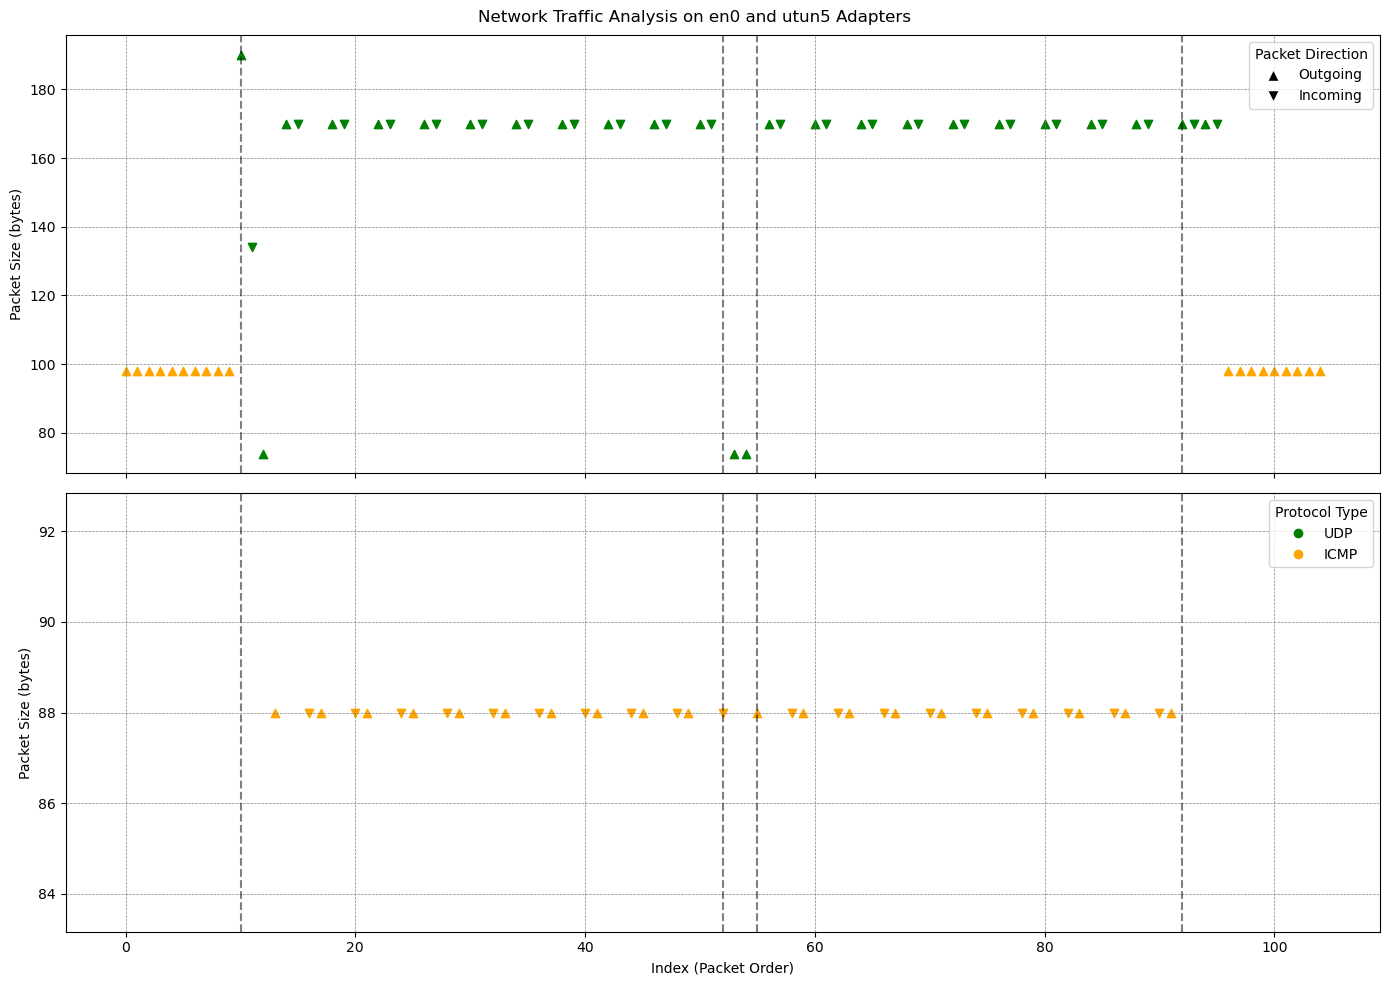

In [6]:
# Define key events by index
wireguard_start_idx = 10
wireguard_stop_idx = 92
ping_pause_start_idx = 52  # Start of ping pause
ping_pause_stop_idx = 55   # End of ping pause

# Define protocol colors for easy differentiation
protocol_colors = {
    "UDP": "green",
    "ICMP": "orange",
}

# Plot settings
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle("Network Traffic Analysis on en0 and utun5 Adapters")

# Scatter plot for en0 adapter
en0_data = traffic[traffic["adapter"] == "en0"]
for i, row in en0_data.iterrows():
    marker = "^" if row["direction"] == "OUTGOING" else "v" if row["direction"] == "INCOMING" else "o"
    ax1.scatter(i, row["len"], color=protocol_colors.get(row["protocol"], "gray"), marker=marker)

ax1.set_ylabel("Packet Size (bytes)")
ax1.grid(True, linestyle="--", lw=0.5, color="gray")

# Scatter plot for utun5 adapter
utun5_data = traffic[traffic["adapter"] == "utun5"]
for i, row in utun5_data.iterrows():
    marker = "^" if row["direction"] == "OUTGOING" else "v" if row["direction"] == "INCOMING" else "o"
    ax2.scatter(i, row["len"], color=protocol_colors.get(row["protocol"], "gray"), marker=marker)

ax2.set_xlabel("Index (Packet Order)")
ax2.set_ylabel("Packet Size (bytes)")
ax2.grid(True, linestyle="--", lw=0.5, color="gray")

# Add vertical lines and labels for WireGuard events and ping pause
event_indices = [wireguard_start_idx, wireguard_stop_idx, ping_pause_start_idx, ping_pause_stop_idx]
for event_idx in event_indices:
    ax1.axvline(event_idx, linestyle="--", color="black", alpha=0.5)
    ax2.axvline(event_idx, linestyle="--", color="black", alpha=0.5)

# Add legend for packet direction and protocol colors
direction_legend = [
    Line2D([0], [0], marker="^", color="w", markerfacecolor="black", markersize=8, label="Outgoing"),
    Line2D([0], [0], marker="v", color="w", markerfacecolor="black", markersize=8, label="Incoming")
]
ax1.legend(handles=direction_legend, loc="upper right", title="Packet Direction")

protocol_legend = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=protocol_colors["UDP"], markersize=8, label="UDP"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor=protocol_colors["ICMP"], markersize=8, label="ICMP"),
]
ax2.legend(handles=protocol_legend, loc="upper right", title="Protocol Type")


plt.tight_layout()
plt.show()


### Analyzing IPs and Protocols of Incoming and Outgoing Traffic
To analyze the unique source and destination IP addresses and protocols used in the incoming and outgoing traffic on the `en0` and `utun5` adapters, we will group the data by direction and protocol and count the unique IP addresses.

In [7]:
# Group data by direction and protocol, collect unique src and dst addresses, and count unique IPs
summary_data = (
    traffic.groupby(["adapter", "direction", "protocol"])
    .agg(
        src_ips=("src", lambda x: ', '.join(x.unique())),
        dst_ips=("dst", lambda x: ', '.join(x.unique())),
    )
    .reset_index()
)

# Separate summaries for each adapter, excluding the 'adapter' column
en0_summary = summary_data[summary_data["adapter"] == "en0"].drop(columns=["adapter"])
utun5_summary = summary_data[summary_data["adapter"] == "utun5"].drop(columns=["adapter"])

print("en0 Adapter Summary:")
display(en0_summary)

print("\nutun5 Adapter Summary:")
display(utun5_summary)


en0 Adapter Summary:


,direction,protocol,src_ips,dst_ips
0,INCOMING,UDP,89.58.29.203,192.168.188.65
1,OUTGOING,ICMP,192.168.188.65,10.0.0.1
2,OUTGOING,UDP,192.168.188.65,89.58.29.203



utun5 Adapter Summary:


,direction,protocol,src_ips,dst_ips
3,INCOMING,ICMP,10.0.0.1,10.0.0.2
4,OUTGOING,ICMP,10.0.0.2,10.0.0.1


### Calculate WireGuard Overhead
When WireGuard encrypts and encapsulates packets, it adds a small overhead to each packet. This overhead is added to the original packet size and can be calculated by comparing the packet sizes before and after WireGuard encryption.
In this case, we will calculate the outgoing and incoming WireGuard overhead by comparing the packet sizes between the `en0` and `utun5` adapters.

In [8]:
# Extract relevant packet sizes from the traffic DataFrame
utun5_outgoing_size = traffic.loc[13, "len"]
en0_outgoing_size = traffic.loc[14, "len"]
en0_incoming_size = traffic.loc[15, "len"]
utun5_incoming_size = traffic.loc[16, "len"]

# Calculate outgoing and incoming WireGuard overhead
outgoing_overhead = en0_outgoing_size - utun5_outgoing_size
incoming_overhead = en0_incoming_size - utun5_incoming_size

# Display results
print(f"Outgoing WireGuard Overhead (utun5 -> en0): {outgoing_overhead} bytes")
print(f"Incoming WireGuard Overhead (en0 -> utun5): {incoming_overhead} bytes")


Outgoing WireGuard Overhead (utun5 -> en0): 82 bytes
Incoming WireGuard Overhead (en0 -> utun5): 82 bytes
